# Question 1

__On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. We want to do some analysis of the average order value (AOV). When we look at orders data over a 30 day window, we naively calculate an AOV of $3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis.__


### __a. Think about what could be going wrong with our calculation. Think about a better way to evaluate this data.__

Let's first explore the dataset to have a better insight into what could be going wrong with the calculation.

In [1]:
import pandas as pd

dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/shopify_datascience_challenge/2019 Winter Data Science Intern Challenge Data Set - Sheet1.csv")
dataset.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


In [2]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   order_id        5000 non-null   int64 
 1   shop_id         5000 non-null   int64 
 2   user_id         5000 non-null   int64 
 3   order_amount    5000 non-null   int64 
 4   total_items     5000 non-null   int64 
 5   payment_method  5000 non-null   object
 6   created_at      5000 non-null   object
dtypes: int64(5), object(2)
memory usage: 273.6+ KB


By just looking at the initial info, we see that we have access to 7 columns, with a total of 5000 rows that have no missing values. 

Let's start by checking the __created_at__ column to see what is our date range:

In [3]:
dataset["created_at"] = pd.to_datetime(dataset["created_at"])

# Date range
first_date = dataset["created_at"].min()
last_date = dataset["created_at"].max()

print("First date: {}".format(first_date))
print("Last date: {}".format(last_date))
print("Number of days: {}".format((last_date - first_date).days))

First date: 2017-03-01 00:08:09
Last date: 2017-03-30 23:55:35
Number of days: 29


We see that the first order, from our dataset, was created the 2017-03-01 00:08:09 and the last order was created the 2017-03-30 23:55:35.

Our dataset is then composed of an entire month of orders. Let's check what value we get by calculating a simple average of all the values in __order_amount__.

In [4]:
AOV = dataset["order_amount"].sum() / dataset["order_amount"].count()
print("Raw AOV: {:.2f}".format(AOV))

Raw AOV: 3145.13


We get the same AOV value when doing this simple average over all the records. Let's investigate more on why this metric could be misleading/flawed.

The first step would be to check the data distribution of all the columns in the given dataset to see if there is anything odd. 



In [5]:
# Since all our orders were created in the same month, let's just focus on the day that the orders were created on
dataset["day"] = dataset["created_at"].dt.day

Let's check what the total/average __order\_amount__ was for each day of the month:

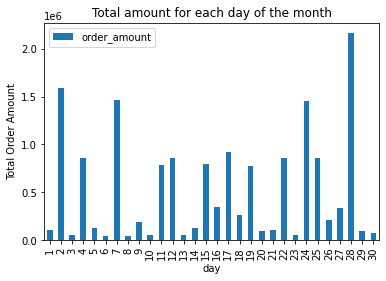

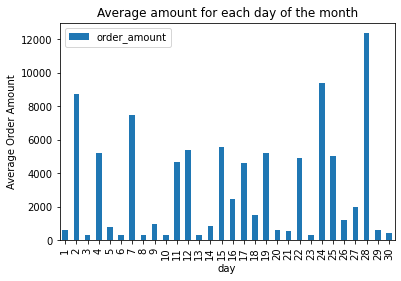

In [6]:
total_amount_per_days = dataset.groupby("day").agg({"order_amount": "sum"}).reset_index()
avg_amount_per_days = dataset.groupby("day").agg({"order_amount": "mean"}).reset_index()

total_amount_per_days.plot(kind="bar", x="day", y="order_amount", title="Total amount for each day of the month", ylabel="Total Order Amount")
avg_amount_per_days.plot(kind="bar", x="day", y="order_amount", title="Average amount for each day of the month", ylabel="Average Order Amount")

The __order\_amount__ seems to be randomly distributed across the days and there are no days where the __order\_amount__ is particularly high or low relative to the others.

Since all the shops only sell one model of shoes, we can figure out the price of said pair for each shop:

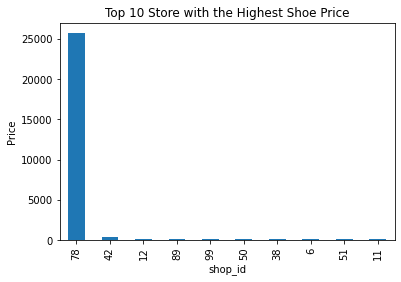

In [7]:
def get_shoe_prices(df_sub):
    return df_sub['order_amount'].sum() / df_sub['total_items'].sum()

dataset.groupby("shop_id").apply(get_shoe_prices).nlargest(10).plot(kind="bar", title="Top 10 Store with the Highest Shoe Price", ylabel="Price")

We see from the plot above that the store with __shop\_id__ = 78 has a significantly high shoe price, compared to the other stores. This could be an error or a niche store that sells high-end shoes. 

Either way, orders made with this store would result in __order\_amount__ larger than normal and drive the AOV up quite significantly.

Next lets check the distributions of total __order\_amount__ per __shop\_id__ and per __user\_id__:

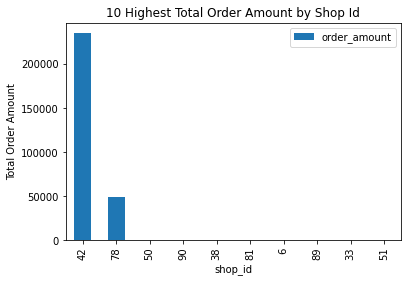

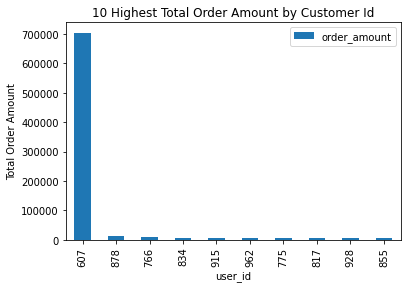

In [8]:
dataset.groupby("shop_id").agg({"order_amount": "mean"}).nlargest(10, 'order_amount').plot(
    kind="bar", title="10 Highest Total Order Amount by Shop Id", ylabel="Total Order Amount"
)

dataset.groupby("user_id").agg({"order_amount": "mean"}).nlargest(10, 'order_amount').plot(
    kind="bar", title="10 Highest Total Order Amount by Customer Id", ylabel="Total Order Amount"
)

We can see from the first plot that there are two stores (__shop\_id__ = 42 and __shop_id__ = 78) that seem to have a higher total order amount compared to the order stores. We can also see, from the second plot, that one user (__user\_id__ = 607) seems to have a significantly higher total __order\_amount__ than the other users.

We know that __shop\_id__ = 78 has a high shoe price, so that would explain why it also has a high total order amount relative to the other stores.

Let's investigate a bit more user 607 to see what is going on:

In [9]:
dataset.loc[dataset["user_id"] == 607]

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,day
15,16,42,607,704000,2000,credit_card,2017-03-07 04:00:00,7
60,61,42,607,704000,2000,credit_card,2017-03-04 04:00:00,4
520,521,42,607,704000,2000,credit_card,2017-03-02 04:00:00,2
1104,1105,42,607,704000,2000,credit_card,2017-03-24 04:00:00,24
1362,1363,42,607,704000,2000,credit_card,2017-03-15 04:00:00,15
1436,1437,42,607,704000,2000,credit_card,2017-03-11 04:00:00,11
1562,1563,42,607,704000,2000,credit_card,2017-03-19 04:00:00,19
1602,1603,42,607,704000,2000,credit_card,2017-03-17 04:00:00,17
2153,2154,42,607,704000,2000,credit_card,2017-03-12 04:00:00,12
2297,2298,42,607,704000,2000,credit_card,2017-03-07 04:00:00,7


We can see that __user\_id__ = 607 made a total of 17 orders, all of which have an __order\_amount__ of 704000 and all were made in __shop\_id__ = 42. 

We now have a better picture of why the AOV is that high (for a relatively affordable item). The orders made by this user have an __order\_amount__ so high (relative to the other orders) that is increasing the AOV quite a lot. Also, all the orders made under __shop\_id__ = 78 are driving the AOV up (since they sell shoes at a significantly higher price than all the other stores).

### __b. What metric would you report for this dataset?__

As we saw from our analysis above, we have outliers in our dataset (orders from __shop\_id__ = 78 and from __user\_id__ = 607) that drive up the value of our "naive" AOV. 

A solution to that would be to use metrics that are less affected by outliers such as median or interquartile range (IQR). The median provides a measure of the center of a dataset while the IQR can be used as a measure of how spread-out the values are (how spread-out the "middle" values are).

Another solution would be to remove those outliers before calculating our metric so that they don't bias the value.

### __c. What is its value?__

Here's what the median and IQR are:

In [10]:
median = dataset["order_amount"].median()
iqr =  dataset["order_amount"].quantile(.75) - dataset["order_amount"].quantile(.25)

print("Median: {}".format(median))
print("IQR: {}".format(iqr))

Median: 284.0
IQR: 227.0


As we can see, these metrics are far less affected by the orders that had huge __order\_amount__.

### __Bonus__

We could also use a machine learning outlier detection method to flag and remove the outliers in our dataset instead of doing the manual exploration work that we did above (to find the orders that had huge order_amount relative to the other data points that we have). We could use an unsupervised clustering algorithm to find data points that should be considered as outliers. 

One clustering that we could use is DBSCAN (Density-based spatial clustering of applications with noise).

It's a density-based clustering algorithm that groups together points that are closely packed together (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions (whose nearest neighbors are too far away).

First step is preprocessing our dataset by doing the following:
1. Select the feature to keep for the clustering
2. One-hot encode the categorical feature (__payment_method__)
3. Standardize features by removing the mean and scaling to unit variance

In [11]:
from sklearn.preprocessing import StandardScaler

# Features that we're gonna keep
features = dataset[["shop_id", "user_id", "order_amount", "payment_method", "day"]]

# One-hot encode our categorical feature (payment_method)
one_hot_features = pd.get_dummies(features)

# Scale our data
train = StandardScaler().fit_transform(one_hot_features)

Next, we can call DBSCAN from sklearn. The two main hyperparameters we need to adjust is __eps__ and __min\_samples__.

- __eps__: The maximum distance between two samples for one to be considered as in the neighborhood of the other (here we are using the euclidean distance).
- __min\_samples__: The number of samples in a neighborhood for a point to be considered as a core point.

For our dataset, an __eps__ = 1 and a __min\_samples__ = 30 seems to produce good results. This means we need at least 30 orders with a euclidean distance of 1 or lower, between their feature vectors, for them not to be considered outliers.

In [12]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=1, min_samples=30).fit(train)

# DBSCAN give a label = -1 for all noise/outlier points
dataset[db.labels_ == -1] 

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,day
15,16,42,607,704000,2000,credit_card,2017-03-07 04:00:00,7
60,61,42,607,704000,2000,credit_card,2017-03-04 04:00:00,4
490,491,78,936,51450,2,debit,2017-03-26 17:08:19,26
493,494,78,983,51450,2,cash,2017-03-16 21:39:35,16
511,512,78,967,51450,2,cash,2017-03-09 07:23:14,9
520,521,42,607,704000,2000,credit_card,2017-03-02 04:00:00,2
617,618,78,760,51450,2,cash,2017-03-18 11:18:42,18
691,692,78,878,154350,6,debit,2017-03-27 22:51:43,27
1104,1105,42,607,704000,2000,credit_card,2017-03-24 04:00:00,24
1259,1260,78,775,77175,3,credit_card,2017-03-27 09:27:20,27


We see that the noise/outliers found by our clustering algo are, in fact, the orders made from __user\_id__ = 607 and from __shop\_id__ = 78 (i.e: orders that had super high __order\_amount__).

To visualize our learned clusters/outliers, we can plot a 3D representation of our feature vector using PCA (with 3 principal components):

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(train)

clusters = pd.DataFrame({
    "principal_components_1": principalComponents[:, 0],
    "principal_components_2": principalComponents[:, 1],
    "principal_components_3": principalComponents[:, 2],
    "cluster": db.labels_ 
})

clusters.head()

,principal_components_1,principal_components_2,principal_components_3,cluster
0,-0.488348,1.639632,0.969759,0
1,-0.704999,1.716569,-0.654937,0
2,-0.620326,1.653765,0.065547,0
3,1.518759,-0.273053,-0.946375,1
4,1.556459,-0.363878,-0.707823,1


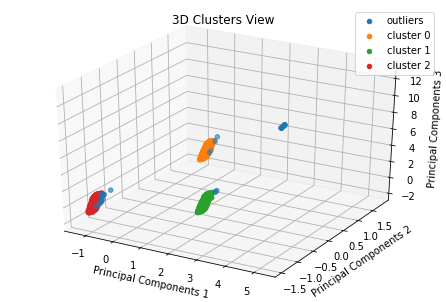

In [14]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = pyplot.figure()
ax = Axes3D(fig)

for cluster_number in np.unique(db.labels_):
    points = clusters.loc[clusters["cluster"] == cluster_number]
    label = f"cluster {cluster_number}" if cluster_number != -1 else "outliers"
    ax.scatter(points["principal_components_1"], points["principal_components_2"], points["principal_components_3"], label=label)

ax.set_xlabel("Principal Components 1")
ax.set_ylabel("Principal Components 2")
ax.set_zlabel("Principal Components 3")
ax.set_title("3D Clusters View")
ax.legend()

pyplot.show()

We can see that the outliers (blue points) are data points that are too far from the 3 main clusters (red, orange, and green).

Finally, if we calculate our AOV again but removing the outliers flagged by our clustering algo we get:

In [15]:
AOV_without_outliers = dataset[db.labels_ != -1]["order_amount"].mean()
print("AOV without outliers: {:.2f}".format(AOV_without_outliers))

AOV without outliers: 461.77


This value makes much more sense than the previous "naive" one, given that we know these shops are selling relatively affordable items.